In [2]:
!python -m pip install spacy==2.3.2 -q

In [3]:
!python -m spacy download pl_core_news_lg # końcówka _lg oznacza rozmiar modelu, mamy jeszcze sm czyli small i md czyli medium

     |████████████████████████████████| 604.2 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pl_core_news_lg')


In [4]:
# pomocnicze
import re
import numpy as np
import pandas as pd
import string
# wizualizacja
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk - do preprocessingu
import nltk
from nltk.stem import WordNetLemmatizer
import spacy
# sklearn - modele do ML
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
# Wczytywanie danych

path = "/content/drive/MyDrive/twity_pobrane/pobrane_twity.csv"
DATASET_COLUMNS=['nr','ids','twit_id','text']
DATASET_ENCODING = "UTF-8"

df = pd.read_csv(path, encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5) # wyświetl N przykładowych wierszy ZAMIAST N wpisać liczbę

,nr,ids,twit_id,text
114856,114855.0,61e5ebf09847038b5dd14d94,1329033759509909505,Właśnie zakończyliśmy konferencję poświęconą w...
101161,101160.0,61e5eb3f9847038b5dd11815,1325743529142984705,"COVID-19 : Co to za różnica na rowerze, czy na..."
21327,21326.0,61e59a619f79a53e23c7b0db,1241290762995879938,"@acosta_re_nata Myślę Renata, że się na mnie n..."
56620,56619.0,61e5e45c058b743f3e37509b,1301422697755406336,25 milionów USD na pomoc w walce z COVID-19 od...
45145,45144.0,61e59de7082f2203773cd045,1254947686190649344,@TygodnikWPROST .@TygodnikWPROST Czy #Chiny na...


In [6]:
df.shape 

(121302, 4)

In [7]:
#zmniejszenie liter
twits =  df["text"].str.lower()

In [8]:
twits[1]

'podejrzenie wirusa coronavirus https://t.co/zbsp0dtgq0'

In [9]:
# Czyszczenie
#Removing link
twits= twits.str.replace(r'http\S+', '')
# Clean mails,  pun ct. and numers
twits = twits.str.replace(r'@\S+', '')
twits = twits.str.replace(r'[^\w\s]', '')
twits = twits.str.replace(r'[0-9]+', '')

In [10]:
twits[1]

'podejrzenie wirusa coronavirus '

In [11]:
# stop words
nlp = spacy.load('pl_core_news_lg') 

In [12]:
stopwordlist = nlp.Defaults.stop_words

In [13]:
# Usunięcie stopwords
twits = twits.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwordlist)]))
twits[2]

'boję wirusa hshshshshs coronavirus'

In [14]:
twits.head()

0                                                 text
1                       podejrzenie wirusa coronavirus
2                   boję wirusa hshshshshs coronavirus
3    pierwszy przypadek wirusa ncov kalifornii trze...
4    coronavirus dotrze polski napotka opór znakomi...
Name: text, dtype: object

In [15]:
twits.isnull().sum()

0

In [16]:
twitsNN = twits.copy()

## Tokenizacja / Steaming

In [17]:
from nltk.tokenize import SpaceTokenizer
space_tokenizer = SpaceTokenizer()

twits = twits.apply(space_tokenizer.tokenize)

In [18]:
twits.head()

0                                               [text]
1                   [podejrzenie, wirusa, coronavirus]
2              [boję, wirusa, hshshshshs, coronavirus]
3    [pierwszy, przypadek, wirusa, ncov, kalifornii...
4    [coronavirus, dotrze, polski, napotka, opór, z...
Name: text, dtype: object

In [19]:
twits[1]

['podejrzenie', 'wirusa', 'coronavirus']

In [20]:
from nltk.stem import *
st = PorterStemmer()

def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return text

In [21]:
twits = twits.apply(lambda x: stemming_on_text(x))
twits.head()

0                                               [text]
1                     [podejrzeni, wirusa, coronaviru]
2                [boję, wirusa, hshshshsh, coronaviru]
3    [pierwszi, przypadek, wirusa, ncov, kalifornii...
4    [coronaviru, dotrz, polski, napotka, opór, zna...
Name: text, dtype: object

In [22]:
twits.to_excel('clean_tweet_token.xlsx',index=False)

## Word embedding

<!-- Word Embeding -->

In [23]:
import pandas as pd
result = pd.read_excel('/content/clean_tweet_token.xlsx')

result

,text
0,['text']
1,"['podejrzeni', 'wirusa', 'coronaviru']"
2,"['boję', 'wirusa', 'hshshshsh', 'coronaviru']"
3,"['pierwszi', 'przypadek', 'wirusa', 'ncov', 'k..."
4,"['coronaviru', 'dotrz', 'polski', 'napotka', '..."
...,...
121297,"['ulta', 'chor', 'kotwal', 'ko', 'dant']"
121298,"['kontrola', 'poselska', 'wykazała', 'szpitaln..."
121299,"['axdx', 'covid', 'sepsi', 'minutetest', 'test..."
121300,"['polska', 'miejscu']"


In [24]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_cv = CountVectorizer(analyzer='word')
X_cv = vectorizer_cv.fit_transform(result['text'])

In [25]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_cv)
result['cluster'] = kmeans.predict(X_cv)

result['Sentiment']=''
result.loc[result['cluster'] == 0 , 'Sentiment'] = 'Negative'
result.loc[result['cluster'] == 1 , 'Sentiment'] = 'positive'


In [26]:
result[result['Sentiment']=='positive'].head()

,text,cluster,Sentiment
4146,"['coronaviru', 'covid', 'wg', 'who', 'szczepio...",1,positive
4152,"['updat', 'zakażonych', 'krajów', 'zmarło', 'p...",1,positive
4153,"['who', 'nadała', 'nazwę', 'nowemu', 'coronavi...",1,positive
4154,"['ncov', 'koronawiruscoronaviru', 'imię', 'cov...",1,positive
4155,"['międzynarodowi', 'komitet', 'taksonomii', 'w...",1,positive


In [27]:
result[result['Sentiment']=='Negative'].head()

,text,cluster,Sentiment
0,['text'],0,Negative
1,"['podejrzeni', 'wirusa', 'coronaviru']",0,Negative
2,"['boję', 'wirusa', 'hshshshsh', 'coronaviru']",0,Negative
3,"['pierwszi', 'przypadek', 'wirusa', 'ncov', 'k...",0,Negative
4,"['coronaviru', 'dotrz', 'polski', 'napotka', '...",0,Negative


# ML

In [28]:
X=result['text']
y=result.cluster

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state =42)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state =42)

In [30]:
X_train

17919     ['drodzi', 'ratownicylekarzestrażacyżołnierz',...
105086    ['szczepionka', 'covid', 'blisko', 'rządami', ...
104233    ['kłamstwo', 'razem', 'wymyślici', 'koronawiru...
103914    ['liczba', 'zgonów', 'mln', 'mieszkańców', 'sp...
45947         ['życi', 'bezpieczeństwo', 'zdrowi', 'ludzi']
                                ...                        
110268         ['przykr', 'walczyć', 'podstawow', 'rzeczi']
119879    ['woronicza', 'zamiast', 'zająć', 'walką', 'co...
103694    ['podobno', 'szczepień', 'przeciw', 'covid', '...
860       ['dr', 'jerzi', 'jaśkowski', 'chiński', 'wiru'...
15795     ['interpretuj', 'korea', 'wiecej', 'przypadkow...
Name: text, Length: 115236, dtype: object

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=43562)

X_train = vectorizer.fit_transform(X_train.apply(lambda x: ''.join(x)))
print('No. of feature_words: ', len(vectorizer.get_feature_names()))

No. of feature_words:  43562


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=43562)
X_test = vectorizer.fit_transform(X_test.apply(lambda x: ''.join(x)))
print('No. of feature_words: ', len(vectorizer.get_feature_names()))

No. of feature_words:  43562


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [33]:
from sklearn.naive_bayes import BernoulliNB
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)

y_pred = BNBmodel.predict(X_test)

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.81      0.68      1386
           1       0.77      0.52      0.62      1647

    accuracy                           0.65      3033
   macro avg       0.68      0.67      0.65      3033
weighted avg       0.69      0.65      0.65      3033



Text(0.5, 1.0, 'Confusion Matrix')

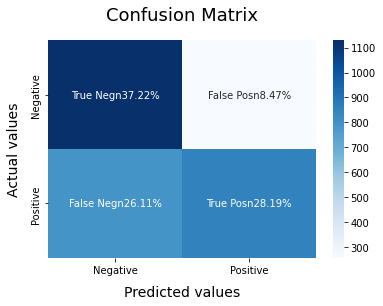

In [35]:
cf_matrix = confusion_matrix(y_test, y_pred)
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

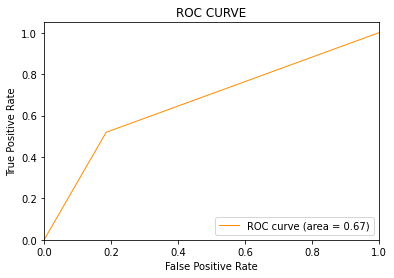

In [36]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [37]:
from sklearn.svm import LinearSVC
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)

y_pred_svm = SVCmodel.predict(X_test)

In [38]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.46      1.00      0.63      1386
           1       0.00      0.00      0.00      1647

    accuracy                           0.46      3033
   macro avg       0.23      0.50      0.31      3033
weighted avg       0.21      0.46      0.29      3033



Text(0.5, 1.0, 'Confusion Matrix')

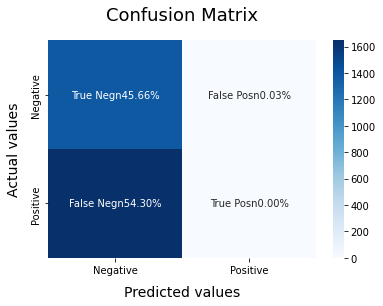

In [39]:
cf_matrix = confusion_matrix(y_test, y_pred_svm)
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

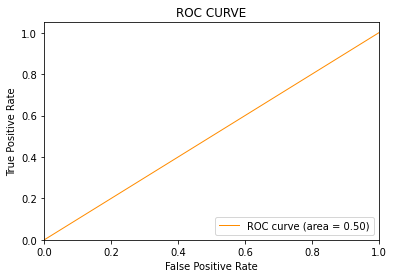

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svm)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [41]:
from sklearn.linear_model import LogisticRegression

LRmodel = LogisticRegression(max_iter = 1000)
LRmodel.fit(X_train, y_train)
y_pred_lr = LRmodel.predict(X_test)

In [42]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.46      1.00      0.63      1386
           1       0.00      0.00      0.00      1647

    accuracy                           0.46      3033
   macro avg       0.23      0.50      0.31      3033
weighted avg       0.21      0.46      0.29      3033



Text(0.5, 1.0, 'Confusion Matrix')

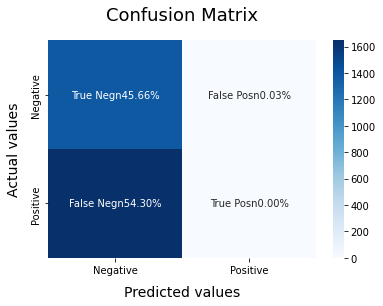

In [43]:
cf_matrix = confusion_matrix(y_test, y_pred_lr)
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

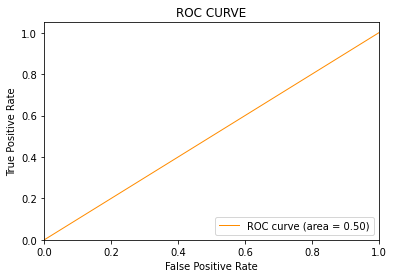

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

# NN

In [45]:
# pomocnicze
import re
import string
import numpy as np
import pandas as pd
import csv

# wizualizacja
import seaborn as sns
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

# preprocessing
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import gensim
from gensim.utils import simple_preprocess

# model
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# ewaluacja
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings('ignore')

In [46]:
max_len = 1000
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(twitsNN)
sequences = tokenizer.texts_to_sequences(twitsNN)
tweets = pad_sequences(sequences, maxlen=max_len)

In [47]:
y_oh=tf.keras.utils.to_categorical(y, 2, dtype="float32")

In [48]:
X_train, X_test, y_train, y_test = train_test_split(tweets, y_oh,test_size = 0.2, random_state=0)
print(len(X_train),len(X_test),len(y_train),len(y_test))

97041 24261 97041 24261


In [50]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
#model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(2,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(X_train, 
                     y_train, 
                     epochs=20, 
                     batch_size=1024,
                     #validation_data=(x_val, labels_val)
)

Epoch 1/20
95/95 [==============================] - 23s 171ms/step - loss: 0.4754 - accuracy: 0.7831
Epoch 2/20
95/95 [==============================] - 15s 158ms/step - loss: 0.1340 - accuracy: 0.9640
Epoch 3/20
95/95 [==============================] - 15s 159ms/step - loss: 0.0523 - accuracy: 0.9887
Epoch 4/20
95/95 [==============================] - 15s 161ms/step - loss: 0.0475 - accuracy: 0.9889
Epoch 5/20
95/95 [==============================] - 15s 162ms/step - loss: 0.0429 - accuracy: 0.9898
Epoch 6/20
95/95 [==============================] - 15s 162ms/step - loss: 0.0415 - accuracy: 0.9901
Epoch 7/20
95/95 [==============================] - 15s 163ms/step - loss: 0.0435 - accuracy: 0.9893
Epoch 8/20
95/95 [==============================] - 15s 163ms/step - loss: 0.0403 - accuracy: 0.9900
Epoch 9/20
95/95 [==============================] - 15s 162ms/step - loss: 0.0414 - accuracy: 0.9897
Epoch 10/20
95/95 [==============================] - 15s 162ms/step - loss: 0.0398 - accura